In [1]:
import pandas as pd 
import numpy as np


**LOADING THE DATASET**

In [2]:
data = pd.read_csv(r"C:\Users\fastf\Downloads\water leakage dataset\location_aware_gis_leakage_dataset.csv")

**PREPROCESSING THE DATASET**


In [3]:
data.head()

,Pressure,Flow_Rate,Temperature,Vibration,RPM,Operational_Hours,Zone,Block,Pipe,Location_Code,Latitude,Longitude,Leakage_Flag
0,64.967142,73.643605,96.607526,2.928288,2104.485874,3380,Zone_4,Block_2,Pipe_3,Zone_4_Block_2_Pipe_3,25.162560,55.238018,0
1,58.617357,73.198788,98.472503,2.983672,2084.997078,2235,Zone_3,Block_4,Pipe_1,Zone_3_Block_4_Pipe_1,25.090473,55.162476,0
2,66.476885,53.065352,97.013095,3.032147,1719.044046,8762,Zone_2,Block_2,Pipe_5,Zone_2_Block_2_Pipe_5,25.279196,55.287601,0
3,75.230299,75.048647,100.552090,3.473431,2173.875267,8931,Zone_5,Block_3,Pipe_2,Zone_5_Block_3_Pipe_2,25.198326,55.269765,0
4,57.658466,90.992436,105.985893,2.626391,1552.975197,3403,Zone_3,Block_1,Pipe_1,Zone_3_Block_1_Pipe_1,25.099630,55.166098,0


In [4]:
data.columns

Index(['Pressure', 'Flow_Rate', 'Temperature', 'Vibration', 'RPM',
       'Operational_Hours', 'Zone', 'Block', 'Pipe', 'Location_Code',
       'Latitude', 'Longitude', 'Leakage_Flag'],
      dtype='object')

In [5]:
data.isnull().sum()

Pressure             0
Flow_Rate            0
Temperature          0
Vibration            0
RPM                  0
Operational_Hours    0
Zone                 0
Block                0
Pipe                 0
Location_Code        0
Latitude             0
Longitude            0
Leakage_Flag         0
dtype: int64

In [6]:
#Encode categorical variables

In [7]:
from sklearn.preprocessing import LabelEncoder
for col in ['Zone', 'Block', 'Pipe', 'Location_Code']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])


In [8]:
X = data.drop(['Leakage_Flag'], axis=1)
y = data['Leakage_Flag']


In [9]:
#Scale numericals features

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [11]:
#Traintest split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**MODEL BUILDING**


In [13]:
#Leak prediction 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       935
           1       1.00      0.97      0.98        65

    accuracy                           1.00      1000
   macro avg       1.00      0.98      0.99      1000
weighted avg       1.00      1.00      1.00      1000



In [15]:
#Cross validation

In [16]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 scores:", scores)
print("Mean F1:", np.mean(scores))


Cross-Validation F1 scores: [1.         0.99212598 0.97637795 1.         0.99224806]
Mean F1: 0.9921503998046756


In [17]:
#Confusion matrix heatmap

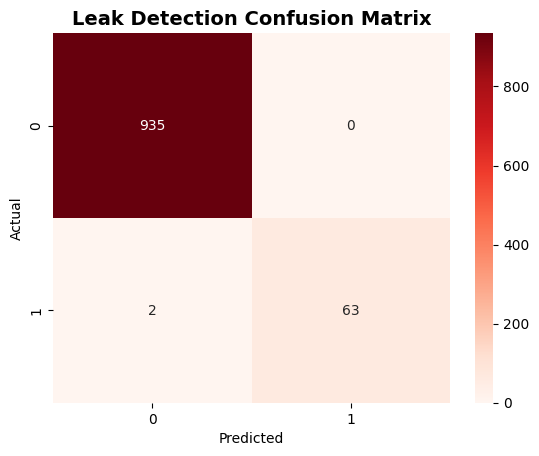

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Leak Detection Confusion Matrix",fontsize=14, fontweight='bold')
plt.show()

In [19]:
#Feature importance

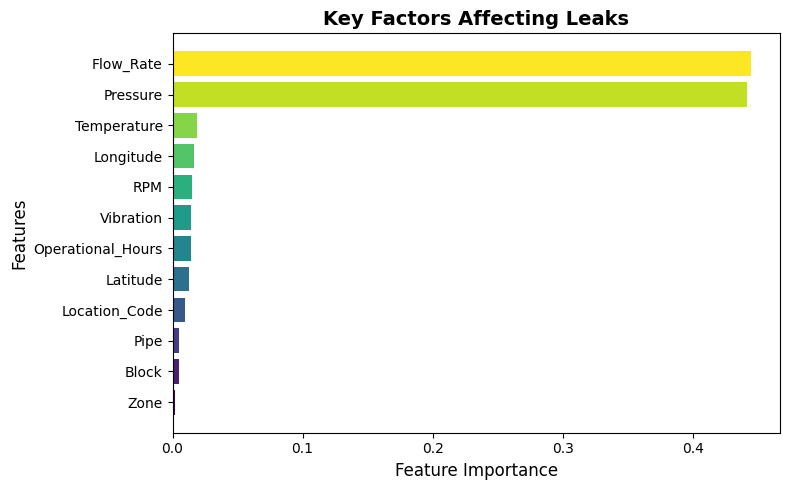

In [20]:
feature_names = data.drop(['Leakage_Flag'], axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names)))

plt.figure(figsize=(8, 5))
plt.barh(feature_names[indices], importances[indices], color=colors[::-1])  
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Key Factors Affecting Leaks", fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

In [21]:
#Anomaly detection

In [22]:
from sklearn.ensemble import IsolationForest
X_num = data[['Pressure', 'Flow_Rate', 'Temperature', 'Vibration', 'RPM', 'Operational_Hours']]
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_model.fit(X_num)
data['Anomaly'] = iso_model.predict(X_num)
data['Anomaly'] = data['Anomaly'].map({1: 0, -1: 1}) 

print(data[['Pressure', 'Flow_Rate', 'Anomaly']].head(10))


    Pressure  Flow_Rate  Anomaly
0  64.967142  73.643605        0
1  58.617357  73.198788        0
2  66.476885  53.065352        0
3  75.230299  75.048647        0
4  57.658466  90.992436        0
5  57.658630  60.886518        0
6  75.792128  95.727240        1
7  67.674347  87.316622        0
8  55.305256  68.986500        0
9  65.425600  77.877055        0


In [23]:
#Time series prediction

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

features = ['Pressure', 'Flow_Rate']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[features])

In [25]:
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]




In [26]:
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

C:\Users\fastf\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0471 - val_loss: 0.0201
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0207 - val_loss: 0.0195
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0203 - val_loss: 0.0196
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0194 - val_loss: 0.0194
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0201 - val_loss: 0.0195
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0195 - val_loss: 0.0195
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0199 - val_loss: 0.0193
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0200 - val_loss: 0.0193
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0199 - val_loss: 0.0199
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


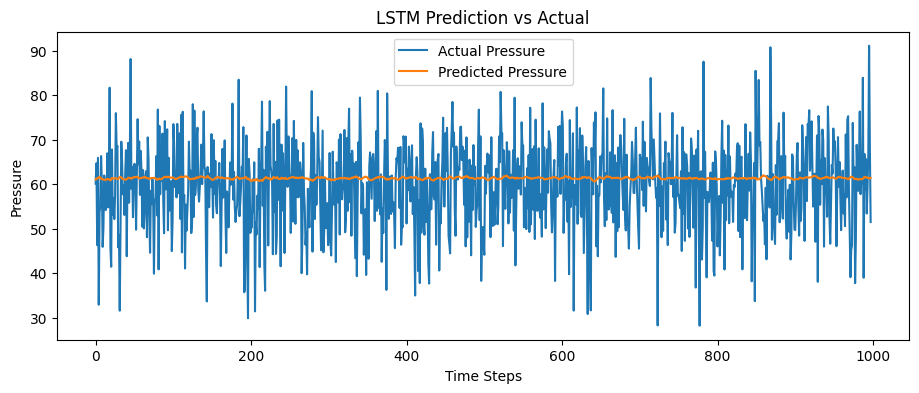

In [27]:
import matplotlib.pyplot as plt
y_pred = model_lstm.predict(X_test)
y_test_rescaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1,1), np.zeros((len(y_test), len(features)-1))), axis=1)
)[:,0]

y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((y_pred, np.zeros((len(y_pred), len(features)-1))), axis=1)
)[:,0]
plt.figure(figsize=(11,4))
plt.plot(y_test_rescaled, label="Actual Pressure")
plt.plot(y_pred_rescaled, label="Predicted Pressure")
plt.title("LSTM Prediction vs Actual")
plt.xlabel("Time Steps")
plt.ylabel("Pressure")
plt.legend()
plt.show()


In [28]:
#Recommendation model

In [29]:
class RecommendationModel:
    def __init__(self):
        pass  

    def predict(self, data):
       
        recommendations = []
        for _, row in data.iterrows():
            actions = []
            if row.get('Leakage_Flag', 0) == 1 or row.get('Anomaly', 0) == 1:
                actions.append("Inspect this pipeline for leaks immediately.")
            if row.get('Flow_Rate', 0) > 50 and row.get('Pressure', 0) < 2:
                actions.append("Possible burst or leak downstream.")
            if row.get('Operational_Hours', 0) > 1000:
                actions.append("Schedule preventive maintenance.")
            if row.get('Temperature', 0) > 70 or row.get('Vibration', 0) > 0.5:
                actions.append("Overheating or pump wear risk.")
            if not actions:
                actions.append("No issues detected.")
            recommendations.append(actions)
        return recommendations
rec_model = RecommendationModel()




In [30]:
#Predictive maintainance model

In [31]:
from sklearn.ensemble import RandomForestRegressor

X = data[['Pressure', 'Flow_Rate', 'Temperature', 'Vibration', 'RPM', 'Operational_Hours']]
y = data['Leakage_Flag']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pm_model = RandomForestRegressor(random_state=42)
pm_model.fit(X_train, y_train)

data['Failure_Risk'] = pm_model.predict(X)
print(data[['Failure_Risk']].tail(20))


      Failure_Risk
4980          0.00
4981          0.00
4982          0.00
4983          0.00
4984          0.00
4985          0.00
4986          0.00
4987          0.00
4988          0.00
4989          0.00
4990          1.00
4991          0.00
4992          0.00
4993          0.00
4994          0.17
4995          0.00
4996          0.00
4997          0.00
4998          0.00
4999          0.00


**VISUALIZATION**

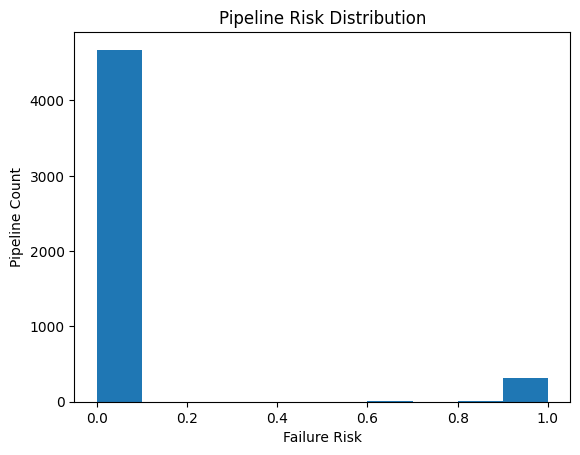

In [32]:
import matplotlib.pyplot as plt

plt.hist(data['Failure_Risk'], bins=10)
plt.xlabel('Failure Risk')
plt.ylabel('Pipeline Count')
plt.title('Pipeline Risk Distribution')
plt.show()



C:\Users\fastf\AppData\Local\Temp\ipykernel_21324\807749613.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Leakage_Flag', data=data, palette='coolwarm')


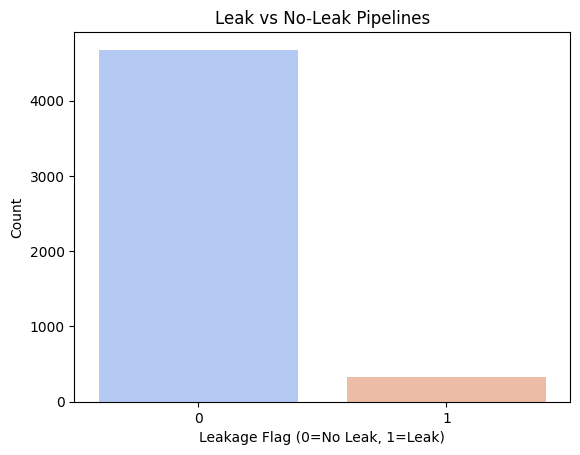

In [33]:
sns.countplot(x='Leakage_Flag', data=data, palette='coolwarm')
plt.title('Leak vs No-Leak Pipelines')
plt.xlabel('Leakage Flag (0=No Leak, 1=Leak)')
plt.ylabel('Count')
plt.show()


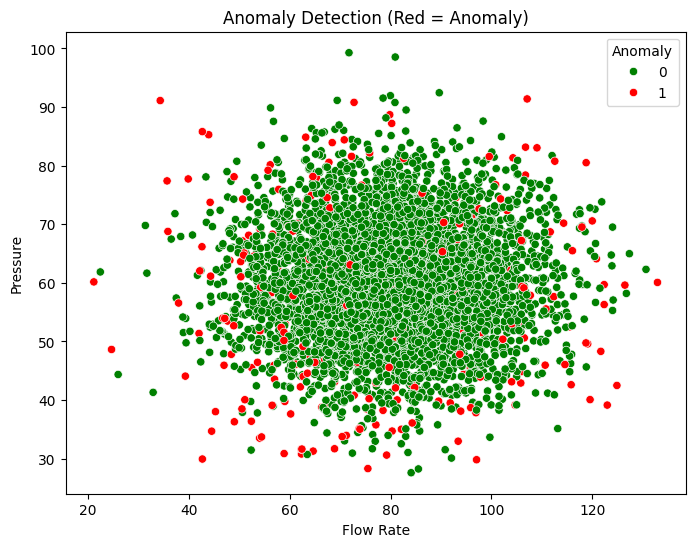

In [34]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Flow_Rate', y='Pressure', hue='Anomaly', data=data, palette={0:'green', 1:'red'})
plt.title('Anomaly Detection (Red = Anomaly)')
plt.xlabel('Flow Rate')
plt.ylabel('Pressure')
plt.show()


In [35]:
import joblib
joblib.dump(rec_model, "models/recommendation_model.pkl")


['models/recommendation_model.pkl']

In [36]:
joblib.dump(model, "models/leak_prediction_rf.pkl")

['models/leak_prediction_rf.pkl']

In [37]:
joblib.dump(pm_model, "models/predictive_maintenance_rf.pkl")


['models/predictive_maintenance_rf.pkl']

In [38]:
joblib.dump(iso_model, "models/isolation_forest.pkl")

['models/isolation_forest.pkl']

In [39]:
model_lstm.save("models/lstm_model.h5")

In [40]:
import os
print(os.getcwd())


C:\Users\fastf


In [42]:
import os
import joblib


save_path = r"C:\Users\fastf\Downloads\SmartPipelineProject"
os.makedirs(save_path, exist_ok=True)


if 'model' in locals():
    joblib.dump(model, os.path.join(save_path, "leak_prediction_rf.pkl"))
if 'pm_model' in locals():
    joblib.dump(pm_model, os.path.join(save_path, "predictive_maintenance_rf.pkl"))
if 'iso_model' in locals():
    joblib.dump(iso_model, os.path.join(save_path, "isolation_forest.pkl"))
if 'recommendation_model' in locals():
    joblib.dump(recommendation_model, os.path.join(save_path, "recommendation_model.pkl"))
if 'model_lstm' in locals():
    model_lstm.save(os.path.join(save_path, "lstm_model.h5"))

print(f"✅ Models saved successfully to {save_path}")


✅ Models saved successfully to C:\Users\fastf\Downloads\SmartPipelineProject
